# Summary

This notebook contains the results of causal fingerprinting. 

# Imports

In [1]:
import os
import sys
sys.path.insert(0, r"..\code")

import cdt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import itertools

from tqdm.notebook import trange, tqdm
from cdt.metrics import SHD
from scipy.linalg import block_diag
from scipy.stats import ks_2samp, anderson_ksamp, cramervonmises_2samp
from utils import load_obj, save_obj

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


## Paths

In [2]:
cdt.SETTINGS.rpath="C:/Program Files/R/R-4.0.0/bin/Rscript"
plt.rcParams['text.usetex'] = True
sns.set_context('talk')

In [3]:
data_dir="../data/"
ts_dir="../data/TimeSeriesAAL/" 
processed="../data/processed/"
diffreg="../data/processed/diff_regions/"
fig_dir="../figs/"

## Regions

In [4]:
right = load_obj('index_right_regions', data_dir=processed)
left = load_obj('index_left_regions', data_dir=processed)

## Subjects

In [5]:
ids = list()

for filename in os.listdir(ts_dir):
    split_= filename.split("_")
    id = split_[1]
    
    if id in ids:continue
    ids.append(id)
len(ids)

100

## Networks

In [6]:
ndetails=5
replace=False
verbose=False

In [7]:
if replace:
    #singlescale
    ss_left_exam0=np.zeros(((len(left),len(left), len(ids))))
    ss_left_exam1=np.zeros(((len(left),len(left), len(ids))))
    ss_right_exam0=np.zeros(((len(right),len(right), len(ids))))
    ss_right_exam1=np.zeros(((len(right),len(right), len(ids))))

    #multiscale
    ms_left_exam0=np.zeros(((ndetails*len(left),ndetails*len(left), len(ids))))
    ms_left_exam1=np.zeros(((ndetails*len(left),ndetails*len(left), len(ids))))
    ms_right_exam0=np.zeros(((ndetails*len(right),ndetails*len(left), len(ids))))
    ms_right_exam1=np.zeros(((ndetails*len(right),ndetails*len(left), len(ids))))

    for filename in os.listdir(diffreg):
        f = os.path.join(diffreg, filename)
        
        if os.path.isfile(f):
            if verbose: print("\n\nStarting {}".format(filename))
            nn=filename.split('.pkl')[0]
            kind=nn.split('_')[1]
            subj=nn.split('_')[3]
            test=nn.split('_')[4][-1:]
            side=nn.split('_')[5][-1:]
            
            if kind=='multiscale' and side=='R' and test=='0': 
                item = load_obj(nn, data_dir=diffreg)['causal_interactions'].squeeze()[1:] #omit the scale coefficients
                bitem = block_diag(*item) #make block-diagonal
                ms_right_exam0[..., ids.index(subj)]+=bitem
            elif kind=='multiscale' and side=='R': 
                item = load_obj(nn, data_dir=diffreg)['causal_interactions'].squeeze()[1:] #omit the scale coefficients
                bitem = block_diag(*item) #make block-diagonal
                ms_right_exam1[..., ids.index(subj)]+=bitem
            elif kind=='multiscale' and side=='L' and test=='0': 
                item = load_obj(nn, data_dir=diffreg)['causal_interactions'].squeeze()[1:] #omit the scale coefficients
                bitem = block_diag(*item) #make block-diagonal
                ms_left_exam0[..., ids.index(subj)]+=bitem
            elif kind=='multiscale' and side=='L': 
                item = load_obj(nn, data_dir=diffreg)['causal_interactions'].squeeze()[1:] #omit the scale coefficients
                bitem = block_diag(*item) #make block-diagonal
                ms_left_exam1[..., ids.index(subj)]+=bitem
            elif kind=='singlescale' and side=='R' and test=='0': 
                ss_right_exam0[..., ids.index(subj)]+=load_obj(nn, data_dir=diffreg)['causal_interactions'][0].squeeze()
            elif kind=='singlescale' and side=='R':
                ss_right_exam1[..., ids.index(subj)]+=load_obj(nn, data_dir=diffreg)['causal_interactions'][0].squeeze()
            elif kind=='singlescale' and side=='L' and test=='0': 
                ss_left_exam0[..., ids.index(subj)]+=load_obj(nn, data_dir=diffreg)['causal_interactions'][0].squeeze()
            else:
                ss_left_exam1[..., ids.index(subj)]+=load_obj(nn, data_dir=diffreg)['causal_interactions'][0].squeeze()

    save_obj(ms_left_exam0, '1.0_ms_left_hemi_exam0', data_dir=processed)
    save_obj(ms_left_exam1, '1.0_ms_left_hemi_exam1', data_dir=processed)
    save_obj(ms_right_exam0, '1.0_ms_right_hemi_exam0', data_dir=processed)
    save_obj(ms_right_exam1, '1.0_ms_right_hemi_exam1', data_dir=processed)

    save_obj(ss_left_exam0, '1.0_ss_left_hemi_exam0', data_dir=processed)
    save_obj(ss_left_exam1, '1.0_ss_left_hemi_exam1', data_dir=processed)
    save_obj(ss_right_exam0, '1.0_ss_right_hemi_exam0', data_dir=processed)
    save_obj(ss_right_exam1, '1.0_ss_right_hemi_exam1', data_dir=processed)

else:
    ms_left_exam0=load_obj('1.0_ms_left_hemi_exam0', data_dir=processed)
    ms_left_exam1=load_obj('1.0_ms_left_hemi_exam1', data_dir=processed)
    ms_right_exam0=load_obj('1.0_ms_right_hemi_exam0', data_dir=processed)
    ms_right_exam1=load_obj('1.0_ms_right_hemi_exam1', data_dir=processed)

    ss_left_exam0=load_obj('1.0_ss_left_hemi_exam0', data_dir=processed)
    ss_left_exam1=load_obj('1.0_ss_left_hemi_exam1', data_dir=processed)
    ss_right_exam0=load_obj('1.0_ss_right_hemi_exam0', data_dir=processed)
    ss_right_exam1=load_obj('1.0_ss_right_hemi_exam1', data_dir=processed)

# Hard-thresholding Analysis

In [8]:
N=len(ids)
K=len(left)
N,K

(100, 45)

In [9]:
thresholds=np.concatenate((np.zeros(1), np.linspace(.01,.09,9), np.linspace(.1,1.,10)))
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.  ])

In [10]:
cardinality_df = pd.DataFrame(index=range(4*N*thresholds.shape[0]), columns=[r'$|\mathcal{E}|$', r'$\tau$', r'side-day'])

for t, threshold in enumerate(tqdm(thresholds)):
    cardinality_df.iloc[4*t*N:(4*t+1)*N,:]=list(zip(np.where(np.absolute(ms_left_exam0)>threshold,1,0).sum(axis=(0,1)), np.ones(N)*threshold, N*['left-0']))
    cardinality_df.iloc[(4*t+1)*N:(4*t+2)*N,:]=list(zip(np.where(np.absolute(ms_right_exam0)>threshold,1,0).sum(axis=(0,1)), np.ones(N)*threshold, N*['right-0']))
    cardinality_df.iloc[(4*t+2)*N:(4*t+3)*N,:]=list(zip(np.where(np.absolute(ms_left_exam1)>threshold,1,0).sum(axis=(0,1)), np.ones(N)*threshold, N*['left-1']))
    cardinality_df.iloc[(4*t+3)*N:(4*t+4)*N,:]=list(zip(np.where(np.absolute(ms_right_exam1)>threshold,1,0).sum(axis=(0,1)), np.ones(N)*threshold, N*['right-1']))

  0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
cardinality_df=cardinality_df.astype({r'$\tau$':float,r'$|\mathcal{E}|$':int, r'side-day':str})
cardinality_df['$|\mathcal{E}|$']=cardinality_df['$|\mathcal{E}|$']/(ndetails*K*(K-1)*.5) #normalize to the size of the complete causal graph

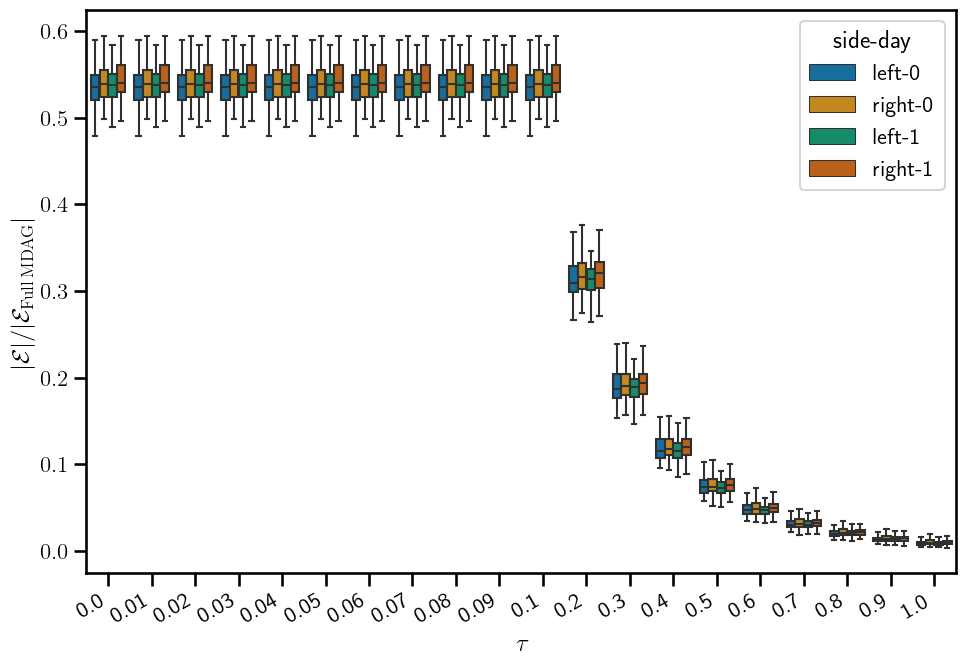

In [12]:
palette='colorblind'
plt.figure(figsize=(10,7))
sns.boxplot(data=cardinality_df, x=r'$\tau$', y=r'$|\mathcal{E}|$', hue=r'side-day', palette=palette, linewidth=1.5, showfliers=False)
plt.xticks(ticks=range(len(thresholds)),labels=np.round(thresholds,2), rotation=30, ha='right')
plt.ylabel(r"$|\mathcal{E}|/|\mathcal{E}_{\mathrm{Full \, MDAG}}|$")
plt.tight_layout()
# plt.savefig(fig_dir+"1.0_hard_thresholding.pdf", dpi=1200)
plt.show()

# Causal fingerprinting

In [13]:
LEGEND_SIZE = 20
SMALL_SIZE = 20
MEDIUM_SIZE = 26
BIGGER_SIZE = 32

plt.rc('font', size=SMALL_SIZE, weight='bold')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

plt.rcParams['text.usetex'] = True

In [14]:
#restrict thresholds
thresholds=np.linspace(.1,1.,10)
thresholds

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [15]:
if replace:
    ms_individuals=np.zeros((2*N, len(thresholds))) #2 regions
    ms_others=np.zeros((2*N*(N-1), len(thresholds))) #2 tests * 2 regions

    ms_individuals_shd=np.zeros((2*N, len(thresholds))) #2 regions
    ms_others_shd=np.zeros((2*N*(N-1), len(thresholds))) #2 tests * 2 regions

    for t,thresh in enumerate(tqdm(thresholds)):
        print('\n\nStarting threshold {}'.format(thresh))

        ms_left_exam0_signed=np.where(np.abs(ms_left_exam0)>thresh, 1, 0)
        ms_left_exam1_signed=np.where(np.abs(ms_left_exam1)>thresh, 1, 0)
        ms_right_exam0_signed=np.where(np.abs(ms_right_exam0)>thresh, 1, 0)
        ms_right_exam1_signed=np.where(np.abs(ms_right_exam1)>thresh, 1, 0)

        #individuals
        for i in trange(N):
            nnz_net1_l=np.flatnonzero(ms_left_exam0_signed[...,i])
            nnz_net2_l=np.flatnonzero(ms_left_exam1_signed[...,i])
            nnz_net1_r=np.flatnonzero(ms_right_exam0_signed[...,i])
            nnz_net2_r=np.flatnonzero(ms_right_exam1_signed[...,i])
            
            nom_l=len(np.intersect1d(nnz_net1_l, nnz_net2_l, assume_unique=False))
            den_l=len(np.union1d(nnz_net1_l, nnz_net2_l))

            nom_r=len(np.intersect1d(nnz_net1_r, nnz_net2_r, assume_unique=False))
            den_r=len(np.union1d(nnz_net1_r, nnz_net2_r))
            
            try:
                if nnz_net1_l.shape[0]>0 or nnz_net2_l.shape[0]>0:
                    ms_individuals[i*2,t] += nom_l/max(den_l,1)
                    ms_individuals_shd[i*2,t]=SHD(ms_left_exam0_signed[...,i], ms_left_exam1_signed[...,i])
                
                if nnz_net1_r.shape[0]>0 or nnz_net2_r.shape[0]>0:
                    ms_individuals[i*2+1,t] += nom_r/max(den_r,1)
                    ms_individuals_shd[i*2+1,t]=SHD(ms_right_exam0_signed[...,i], ms_right_exam1_signed[...,i])            

            except Exception as e:
                print('Subject {}, individual metrics, {}'.format(ids[i], e))
                pass
        print('Individuals done.')

        #others
        counter=0
        for i,j in tqdm(itertools.combinations(range(N),2)):

            nnz_net1_l_0=np.flatnonzero(ms_left_exam0_signed[...,i])
            nnz_net2_l_0=np.flatnonzero(ms_left_exam0_signed[...,j])
            nnz_net1_r_0=np.flatnonzero(ms_right_exam0_signed[...,i])
            nnz_net2_r_0=np.flatnonzero(ms_right_exam0_signed[...,j])
            
            nnz_net1_l_1=np.flatnonzero(ms_left_exam1_signed[...,i])
            nnz_net2_l_1=np.flatnonzero(ms_left_exam1_signed[...,j])
            nnz_net1_r_1=np.flatnonzero(ms_right_exam1_signed[...,i])
            nnz_net2_r_1=np.flatnonzero(ms_right_exam1_signed[...,j])
            
            nom_l_0=len(np.intersect1d(nnz_net1_l_0, nnz_net2_l_0, assume_unique=False))
            den_l_0=len(np.union1d(nnz_net1_l_0, nnz_net2_l_0))
            nom_r_0=len(np.intersect1d(nnz_net1_r_0, nnz_net2_r_0, assume_unique=False))
            den_r_0=len(np.union1d(nnz_net1_r_0, nnz_net2_r_0))

            nom_l_1=len(np.intersect1d(nnz_net1_l_1, nnz_net2_l_1, assume_unique=False))
            den_l_1=len(np.union1d(nnz_net1_l_1, nnz_net2_l_1))
            nom_r_1=len(np.intersect1d(nnz_net1_r_1, nnz_net2_r_1, assume_unique=False))
            den_r_1=len(np.union1d(nnz_net1_r_1, nnz_net2_r_1))
            
            try:
                if nnz_net1_l_0.shape[0]>0 or nnz_net2_l_0.shape[0]>0:
                    ms_others[counter*4,t] += nom_l_0/max(den_l_0,1)
                    ms_others_shd[counter*4,t] += SHD(ms_left_exam0_signed[...,i], ms_left_exam0_signed[...,j])
                
                if nnz_net1_r_0.shape[0]>0 or nnz_net2_r_0.shape[0]>0:
                    ms_others[counter*4+1,t] += nom_r_0/max(den_r_0,1)
                    ms_others_shd[counter*4+1,t] += SHD(ms_right_exam0_signed[...,i], ms_right_exam0_signed[...,j])

                if nnz_net1_l_1.shape[0]>0 or nnz_net2_l_1.shape[0]>0:
                    ms_others[counter*4+2,t] += nom_l_1/max(den_l_1,1)
                    ms_others_shd[counter*4+2,t] += SHD(ms_left_exam1_signed[...,i], ms_left_exam1_signed[...,j])
                
                if nnz_net1_r_1.shape[0]>0 or nnz_net2_r_1.shape[0]>0:
                    ms_others[counter*4+3,t] += nom_r_1/max(den_r_1,1)
                    ms_others_shd[counter*4+3,t] += SHD(ms_right_exam1_signed[...,i], ms_right_exam1_signed[...,j])
                
            except Exception as e:
                print('Pair ({},{}): {}'.format(ids[i],ids[j],e))
                pass

            counter+=1
        print('Others done.')

    save_obj(ms_individuals, '1.0_ms_individuals', data_dir=processed)
    save_obj(ms_others, '1.0_ms_others', data_dir=processed)
    save_obj(ms_individuals_shd, '1.0_ms_individuals_shd', data_dir=processed)
    save_obj(ms_others_shd, '1.0_ms_others_shd', data_dir=processed)

else:
    ms_individuals=load_obj('1.0_ms_individuals', data_dir=processed)
    ms_others=load_obj('1.0_ms_others', data_dir=processed)
    ms_individuals_shd=load_obj('1.0_ms_individuals_shd', data_dir=processed)
    ms_others_shd=load_obj('1.0_ms_others_shd', data_dir=processed)

In [16]:
# These tests compares the underlying distributions of two independent samples. 
# The null is that the distributions are the identical. 
# The null is rejected, thus distributions are different.

for t, thresh in enumerate(thresholds):
    print("\n\n threshold {}".format(thresh))

    print("\n++++++++++++++++++")
    print("Jaccard")
    print("++++++++++++++++++")
    print(ks_2samp(ms_individuals[...,t],ms_others[...,t]))
    print(cramervonmises_2samp(ms_individuals[...,t],ms_others[...,t]))
    print(anderson_ksamp((ms_individuals[...,t],ms_others[...,t])))

    print("\n++++++++++++++++++")
    print("SHD")
    print("++++++++++++++++++")
    print(ks_2samp(ms_individuals_shd[...,t],ms_others_shd[...,t]))
    print(cramervonmises_2samp(ms_individuals_shd[...,t],ms_others_shd[...,t]))
    print(anderson_ksamp((ms_individuals_shd[...,t],ms_others_shd[...,t])))



 threshold 0.1

++++++++++++++++++
Jaccard
++++++++++++++++++
KstestResult(statistic=0.6426262626262627, pvalue=3.859300913675067e-80, statistic_location=0.38621047174701917, statistic_sign=-1)
CramerVonMisesResult(statistic=40.381966539141416, pvalue=1.2557682671499037e-08)
Anderson_ksampResult(statistic=450.64685349954357, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)

++++++++++++++++++
SHD
++++++++++++++++++
KstestResult(statistic=0.8072727272727273, pvalue=2.38264365773571e-140, statistic_location=2376.0, statistic_sign=1)
CramerVonMisesResult(statistic=53.82647572222223, pvalue=6.831464061107795e-09)
Anderson_ksampResult(statistic=681.121540650239, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)


 threshold 0.2

++++++++++++++++++
Jaccard
++++++++++++++++++
KstestResult(statistic=0.687070707070707, pvalue=1.5030623286123198e-93, statistic_location=0.27051330086174596, statistic_sign=-1)
CramerVon

p-value floored: true value smaller than 0.001
p-value floored: true value smaller than 0.001


In [17]:
data1=list(zip(ms_individuals.flatten(order='F'), ms_individuals_shd.flatten(order='F'), np.kron(thresholds, np.ones(ms_individuals.shape[0]))))
toplot1 = pd.DataFrame(data=data1, columns=['Jacc', 'SHD', '$\\tau$'])
toplot1['kind'] = 'Same subject'

data2=list(zip(ms_others.flatten(order='F'), ms_others_shd.flatten(order='F'), np.kron(thresholds, np.ones(ms_others.shape[0]))))
toplot2 = pd.DataFrame(data=data2, columns=['Jacc', 'SHD','$\\tau$'])
toplot2['kind'] = 'Diff subjects'

to_plot_ic = pd.concat((toplot1,toplot2))

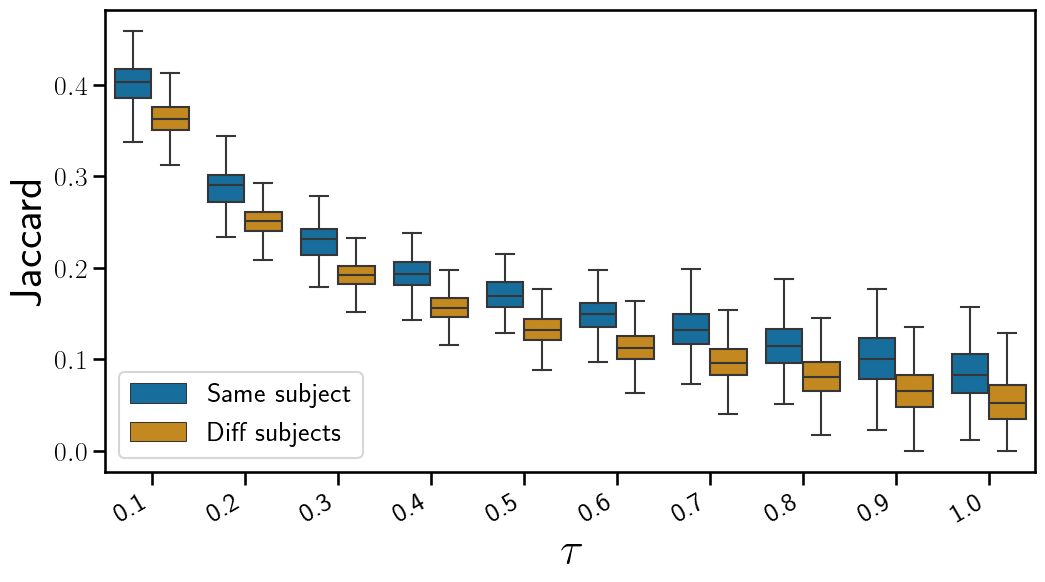

In [19]:
palette='colorblind'
fig = plt.figure(figsize=(12,6))
g=sns.boxplot(data=to_plot_ic, x='$\\tau$', y='Jacc', hue='kind', palette=palette, showfliers=False, linewidth=1.5)
g.set_xticklabels(np.round(thresholds,2),rotation=30, ha='right')
plt.legend(loc=3)
plt.ylabel('Jaccard')
# plt.savefig(fig_dir+"1.0_Jaccard_individual_combos.pdf", dpi=1200, bbox_inches='tight')
plt.show()


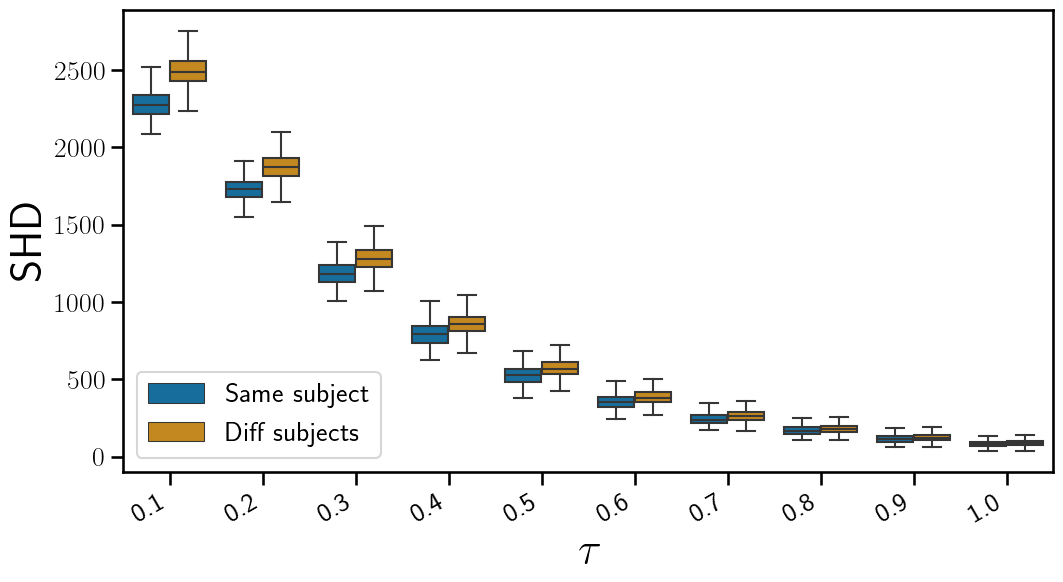

In [20]:
fig = plt.figure(figsize=(12,6))
g=sns.boxplot(data=to_plot_ic, x='$\\tau$', y='SHD', hue='kind', palette=palette, showfliers=False, linewidth=1.5)
g.set_xticklabels(np.round(thresholds,2),rotation=30, ha='right')
plt.legend(loc=3)
# plt.savefig(fig_dir+"1.0_SHD_individual_combos.pdf", dpi=1200, bbox_inches='tight')
plt.show()


# Analysis Left vs Right Hemisphere

H0: Dist(measure(L0,L1),measure(R0,R1))=Dist(measure(L0,R1),measure(R0,L1))

In [21]:
ms_sameside=load_obj('1.0_ms_individuals', data_dir=processed) #it coincides with individuals diff days
ms_sameside_shd=load_obj('1.0_ms_individuals_shd', data_dir=processed) #it coincides with individuals diff days

if replace:
    ms_diffsides=np.zeros((2*N, len(thresholds))) #2 tests * 2 regions
    ms_diffsides_shd=np.zeros((2*N, len(thresholds))) #2 tests * 2 regions

    for t,thresh in enumerate(thresholds):
        print('\n\nStarting threshold {}'.format(thresh))

        ms_left_exam0_signed=np.where(np.abs(ms_left_exam0)>thresh, 1, 0)
        ms_left_exam1_signed=np.where(np.abs(ms_left_exam1)>thresh, 1, 0)
        ms_right_exam0_signed=np.where(np.abs(ms_right_exam0)>thresh, 1, 0)
        ms_right_exam1_signed=np.where(np.abs(ms_right_exam1)>thresh, 1, 0)

        #individuals
        for i in range(N):
            nnz_net1_l=np.flatnonzero(ms_left_exam0_signed[...,i])
            nnz_net2_l=np.flatnonzero(ms_left_exam1_signed[...,i])
            nnz_net1_r=np.flatnonzero(ms_right_exam0_signed[...,i])
            nnz_net2_r=np.flatnonzero(ms_right_exam1_signed[...,i])
            
            nom_lr=len(np.intersect1d(nnz_net1_l, nnz_net2_r, assume_unique=False))
            den_lr=len(np.union1d(nnz_net1_l, nnz_net2_r))

            nom_rl=len(np.intersect1d(nnz_net1_r, nnz_net2_l, assume_unique=False))
            den_rl=len(np.union1d(nnz_net1_r, nnz_net2_l))
            
            try:
                ms_diffsides[i*2,t] += nom_lr/max(den_lr,1)
                ms_diffsides[i*2+1,t] += nom_rl/max(den_rl,1)
                ms_diffsides_shd[i*2,t] += SHD(ms_left_exam0_signed[...,i], ms_right_exam1_signed[...,i])
                ms_diffsides_shd[i*2+1,t] += SHD(ms_left_exam1_signed[...,i], ms_right_exam0_signed[...,i])
            except Exception as e:
                print('Subject {}, {}'.format(ids[i], e))
                pass
        print('Individuals done.')

    save_obj(ms_diffsides, '1.0_ms_diffsides', data_dir=processed)
    save_obj(ms_diffsides_shd, '1.0_ms_diffsides_shd', data_dir=processed)
else:
    ms_diffsides=load_obj('1.0_ms_diffsides', data_dir=processed)
    ms_diffsides_shd=load_obj('1.0_ms_diffsides_shd', data_dir=processed)

In [22]:
for t, thresh in enumerate(thresholds):
    print("\n\n threshold {}".format(thresh))
    print("\n++++++++++++++++++")
    print("Jaccard")
    print("++++++++++++++++++")

    print(ks_2samp(ms_sameside[...,t],ms_diffsides[...,t]))
    print(cramervonmises_2samp(ms_sameside[...,t],ms_diffsides[...,t]))
    print(anderson_ksamp((ms_sameside[...,t],ms_diffsides[...,t])))

    print("\n++++++++++++++++++")
    print("SHD")
    print("++++++++++++++++++")
    print(ks_2samp(ms_sameside_shd[...,t],ms_diffsides_shd[...,t]))
    print(cramervonmises_2samp(ms_sameside_shd[...,t],ms_diffsides_shd[...,t]))
    print(anderson_ksamp((ms_sameside_shd[...,t],ms_diffsides_shd[...,t])))



 threshold 0.1

++++++++++++++++++
Jaccard
++++++++++++++++++
KstestResult(statistic=0.64, pvalue=7.809864998248257e-39, statistic_location=0.38252862120457937, statistic_sign=-1)
CramerVonMisesResult(statistic=19.98021874999999, pvalue=8.517322402923355e-10)
Anderson_ksampResult(statistic=125.7574493189331, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)

++++++++++++++++++
SHD
++++++++++++++++++
KstestResult(statistic=0.825, pvalue=4.795451191824928e-69, statistic_location=2393.0, statistic_sign=1)
CramerVonMisesResult(statistic=27.5116625, pvalue=1.3833858392153786e-08)
Anderson_ksampResult(statistic=170.48153914291572, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)


 threshold 0.2

++++++++++++++++++
Jaccard
++++++++++++++++++
KstestResult(statistic=0.64, pvalue=7.809864998248257e-39, statistic_location=0.2681102362204724, statistic_sign=-1)
CramerVonMisesResult(statistic=19.996506249999996, pvalue=

p-value floored: true value smaller than 0.001
p-value floored: true value smaller than 0.001


In [23]:
data1=list(zip(ms_sameside.flatten(order='F'), ms_sameside_shd.flatten(order='F'), np.kron(thresholds, np.ones(ms_sameside.shape[0]))))
toplot1 = pd.DataFrame(data=data1, columns=['Jacc', 'SHD', '$\\tau$'])
toplot1['kind'] = 'Same hemisphere'

data2=list(zip(ms_diffsides.flatten(order='F'), ms_diffsides_shd.flatten(order='F'), np.kron(thresholds, np.ones(ms_diffsides.shape[0]))))
toplot2 = pd.DataFrame(data=data2, columns=['Jacc', 'SHD', '$\\tau$'])
toplot2['kind'] = 'Diff hemispheres'

to_plot_lr = pd.concat((toplot1,toplot2))

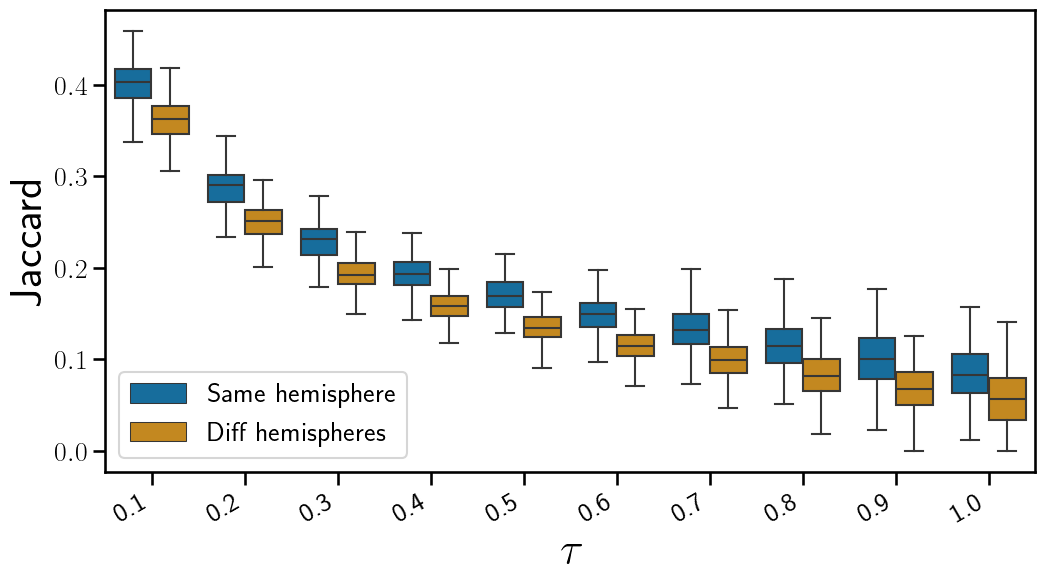

In [24]:
fig = plt.figure(figsize=(12,6))
g=sns.boxplot(data=to_plot_lr, x='$\\tau$', y='Jacc', hue='kind', palette=palette, showfliers=False, linewidth=1.5)
g.set_xticklabels(np.round(thresholds,2),rotation=30, ha='right')
plt.legend(loc=3)
plt.ylabel('Jaccard')
# plt.savefig(fig_dir+"1.0_Jaccard_left_right.pdf", dpi=1200, bbox_inches='tight')
plt.show()


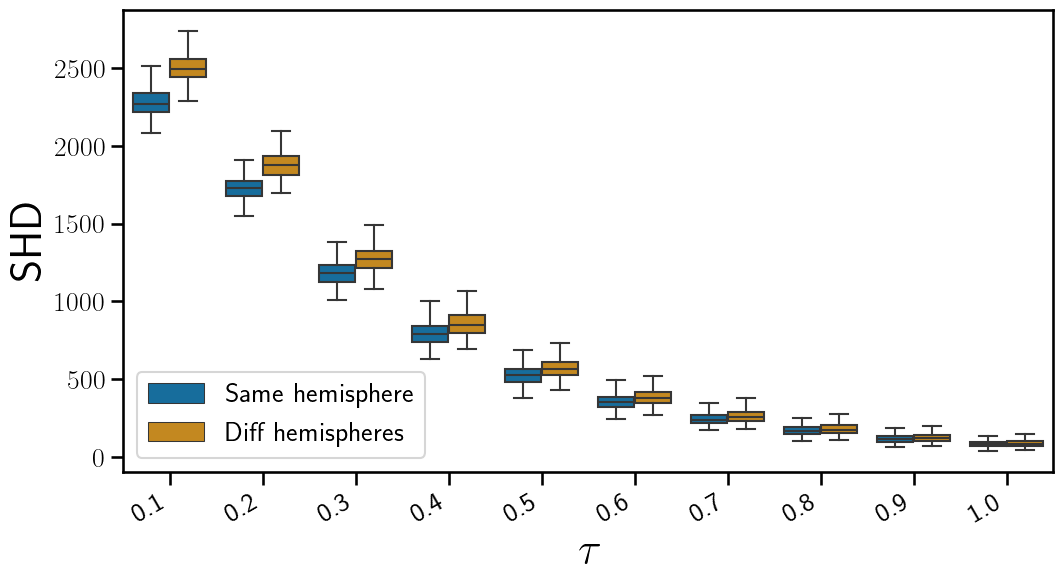

In [25]:
fig = plt.figure(figsize=(12,6))
g=sns.boxplot(data=to_plot_lr, x='$\\tau$', y='SHD', hue='kind', palette=palette, showfliers=False, linewidth=1.5)
g.set_xticklabels(np.round(thresholds,2),rotation=30, ha='right')
plt.legend(loc=3)
# plt.savefig(fig_dir+"1.0_SHD_left_right.pdf", dpi=1200, bbox_inches='tight')
plt.show()

# Analysis Test 0 vs Test 1

H0: Dist(Jacc(L0_i,L0_j),Jacc(R0_i,R0_j))=Dist(Jacc(L1_i,L1_j),Jacc(R1_i,R1_j))

In [26]:
if replace:
    ms_day1=np.zeros((N*(N-1), len(thresholds))) #2 regions
    ms_day2=np.zeros((N*(N-1), len(thresholds))) #2 tests * 2 regions

    ms_day1_shd=np.zeros((N*(N-1), len(thresholds))) #2 regions
    ms_day2_shd=np.zeros((N*(N-1), len(thresholds))) #2 tests * 2 regions

    for t,thresh in enumerate(thresholds):
        print('\n\nStarting threshold {}'.format(thresh))

        ms_left_exam0_signed=np.where(np.abs(ms_left_exam0)>thresh, 1, 0)
        ms_left_exam1_signed=np.where(np.abs(ms_left_exam1)>thresh, 1, 0)
        ms_right_exam0_signed=np.where(np.abs(ms_right_exam0)>thresh, 1, 0)
        ms_right_exam1_signed=np.where(np.abs(ms_right_exam1)>thresh, 1, 0)

        #others
        counter=0
        for i,j in itertools.combinations(range(N),2):
            nnz_net1_l_0=np.flatnonzero(ms_left_exam0_signed[...,i])
            nnz_net2_l_0=np.flatnonzero(ms_left_exam0_signed[...,j])
            nnz_net1_r_0=np.flatnonzero(ms_right_exam0_signed[...,i])
            nnz_net2_r_0=np.flatnonzero(ms_right_exam0_signed[...,j])
            
            nnz_net1_l_1=np.flatnonzero(ms_left_exam1_signed[...,i])
            nnz_net2_l_1=np.flatnonzero(ms_left_exam1_signed[...,j])
            nnz_net1_r_1=np.flatnonzero(ms_right_exam1_signed[...,i])
            nnz_net2_r_1=np.flatnonzero(ms_right_exam1_signed[...,j])
            
            nom_l_0=len(np.intersect1d(nnz_net1_l_0, nnz_net2_l_0, assume_unique=False))
            den_l_0=len(np.union1d(nnz_net1_l_0, nnz_net2_l_0))
            nom_r_0=len(np.intersect1d(nnz_net1_r_0, nnz_net2_r_0, assume_unique=False))
            den_r_0=len(np.union1d(nnz_net1_r_0, nnz_net2_r_0))

            nom_l_1=len(np.intersect1d(nnz_net1_l_1, nnz_net2_l_1, assume_unique=False))
            den_l_1=len(np.union1d(nnz_net1_l_1, nnz_net2_l_1))
            nom_r_1=len(np.intersect1d(nnz_net1_r_1, nnz_net2_r_1, assume_unique=False))
            den_r_1=len(np.union1d(nnz_net1_r_1, nnz_net2_r_1))
            
            try:
                ms_day1[counter*2,t] += nom_l_0/max(den_l_0,1)
                ms_day1[counter*2+1,t] += nom_r_0/max(den_r_0,1)
                ms_day2[counter*2,t] += nom_l_1/max(den_l_1,1)
                ms_day2[counter*2+1,t] += nom_r_1/max(den_r_1,1)

                ms_day1_shd[counter*2,t] += SHD(ms_left_exam0_signed[...,i], ms_left_exam0_signed[...,j])
                ms_day1_shd[counter*2+1,t] += SHD(ms_right_exam0_signed[...,i], ms_right_exam0_signed[...,j])
                ms_day2_shd[counter*2,t] += SHD(ms_left_exam1_signed[...,i], ms_left_exam1_signed[...,j])
                ms_day2_shd[counter*2+1,t] += SHD(ms_right_exam1_signed[...,i], ms_right_exam1_signed[...,j])
            except Exception as e:
                print('Pair ({},{}): {}'.format(ids[i],ids[j],e))
                pass

            counter+=1
        print('Combinations done.')

    save_obj(ms_day1, '1.0_ms_day1', data_dir=processed)
    save_obj(ms_day2, '1.0_ms_day2', data_dir=processed)
    save_obj(ms_day1_shd, '1.0_ms_day1_shd', data_dir=processed)
    save_obj(ms_day2_shd, '1.0_ms_day2_shd', data_dir=processed)

else:
    ms_day1=load_obj('1.0_ms_day1', data_dir=processed)
    ms_day2=load_obj('1.0_ms_day2', data_dir=processed)
    ms_day1_shd=load_obj('1.0_ms_day1_shd', data_dir=processed)
    ms_day2_shd=load_obj('1.0_ms_day2_shd', data_dir=processed)

In [27]:
for t, thresh in enumerate(thresholds):
    print("\n\n threshold {}".format(thresh))
    
    print("\n++++++++++++++++++")
    print("Jaccard")
    print("++++++++++++++++++")
    print(ks_2samp(ms_day1[...,t],ms_day2[...,t]))
    print(cramervonmises_2samp(ms_day1[...,t],ms_day2[...,t]))
    print(anderson_ksamp((ms_day1[...,t],ms_day2[...,t])))

    print("\n++++++++++++++++++")
    print("SHD")
    print("++++++++++++++++++")
    print(ks_2samp(ms_day1_shd[...,t],ms_day2_shd[...,t]))
    print(cramervonmises_2samp(ms_day1_shd[...,t],ms_day2_shd[...,t]))
    print(anderson_ksamp((ms_day1_shd[...,t],ms_day2_shd[...,t])))



 threshold 0.1

++++++++++++++++++
Jaccard
++++++++++++++++++
KstestResult(statistic=0.03939393939393939, pvalue=4.239336441047031e-07, statistic_location=0.3736144904028116, statistic_sign=1)
CramerVonMisesResult(statistic=1.94114640342832, pvalue=1.7329210521443983e-05)
Anderson_ksampResult(statistic=12.028808689866532, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)

++++++++++++++++++
SHD
++++++++++++++++++
KstestResult(statistic=0.012121212121212121, pvalue=0.46109038107912825, statistic_location=2419.0, statistic_sign=-1)
CramerVonMisesResult(statistic=0.10231071574344242, pvalue=0.5737114980484209)
Anderson_ksampResult(statistic=-0.01628269389502962, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.25)


 threshold 0.2

++++++++++++++++++
Jaccard
++++++++++++++++++
KstestResult(statistic=0.023333333333333334, pvalue=0.009121966932575434, statistic_location=0.24052181002853648, statistic_sign=-1)
CramerVo

p-value floored: true value smaller than 0.001
p-value capped: true value larger than 0.25
p-value floored: true value smaller than 0.001


In [28]:
data1=list(zip(ms_day1.flatten(order='F'), ms_day1_shd.flatten(order='F'), np.kron(thresholds, np.ones(ms_day1.shape[0]))))
toplot1 = pd.DataFrame(data=data1, columns=['Jacc', 'SHD', '$\\tau$'])
toplot1['kind'] = '$t_1$'

data2=list(zip(ms_day2.flatten(order='F'), ms_day2_shd.flatten(order='F'), np.kron(thresholds, np.ones(ms_day2.shape[0]))))
toplot2 = pd.DataFrame(data=data2, columns=['Jacc', 'SHD', '$\\tau$'])
toplot2['kind'] = '$t_2$'

to_plot_t1t2 = pd.concat((toplot1,toplot2))

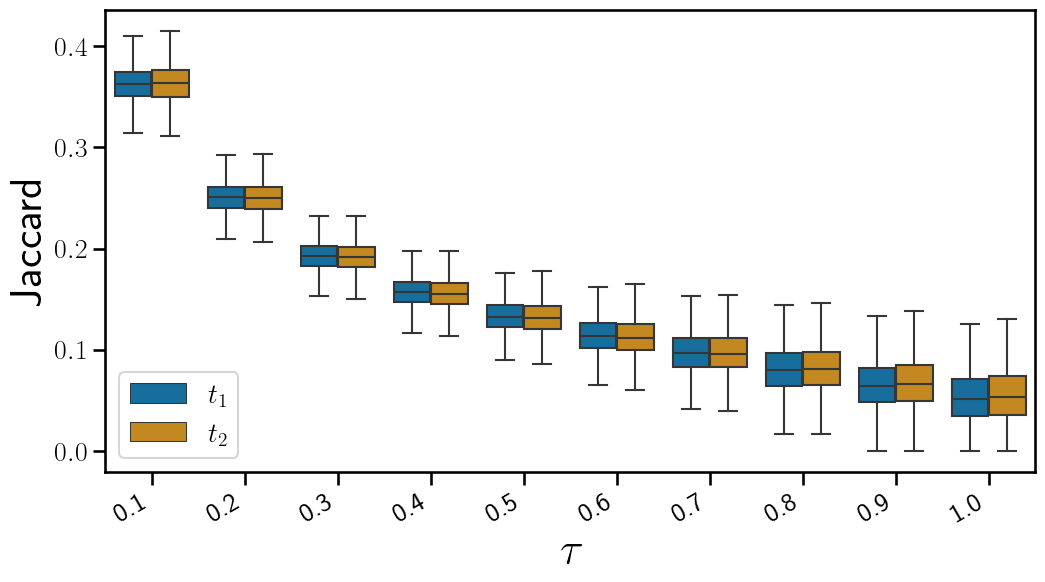

In [29]:
fig = plt.figure(figsize=(12,6))
g=sns.boxplot(data=to_plot_t1t2, x='$\\tau$', y='Jacc', hue='kind', palette=palette, showfliers=False, linewidth=1.5)
g.set_xticklabels(np.round(thresholds,2),rotation=30, ha='right')
plt.legend(loc=3)
plt.ylabel('Jaccard')
# plt.savefig(fig_dir+"1.0_Jaccard_t1_t2.pdf", dpi=1200, bbox_inches='tight')
plt.show()

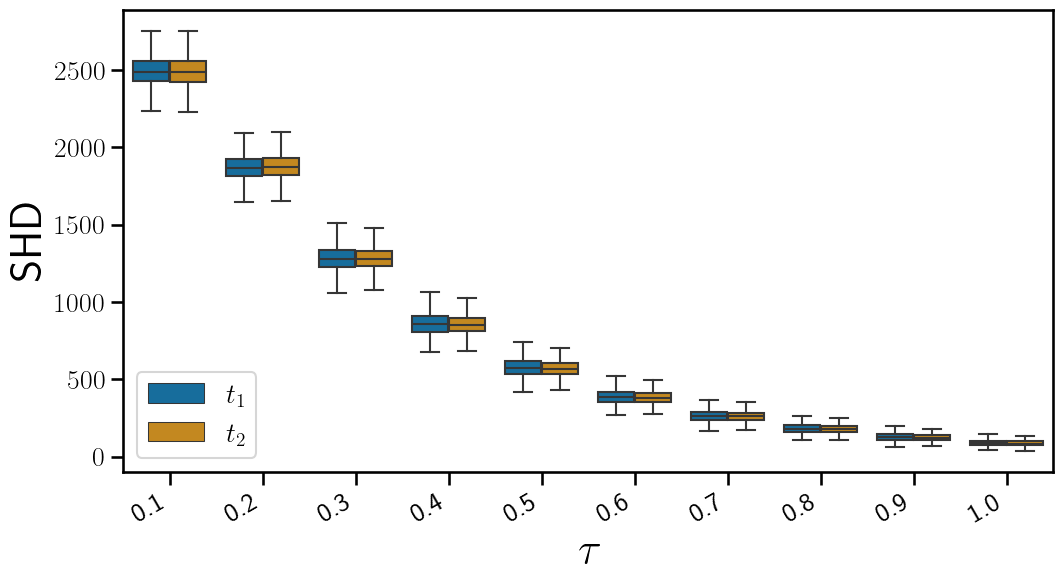

In [30]:
fig = plt.figure(figsize=(12,6))
g=sns.boxplot(data=to_plot_t1t2, x='$\\tau$', y='SHD', hue='kind', palette=palette, showfliers=False, linewidth=1.5)
g.set_xticklabels(np.round(thresholds,2),rotation=30, ha='right')
plt.legend(loc=3)
# plt.savefig(fig_dir+"1.0_SHD_t1_t2.pdf", dpi=1200, bbox_inches='tight')
plt.show()

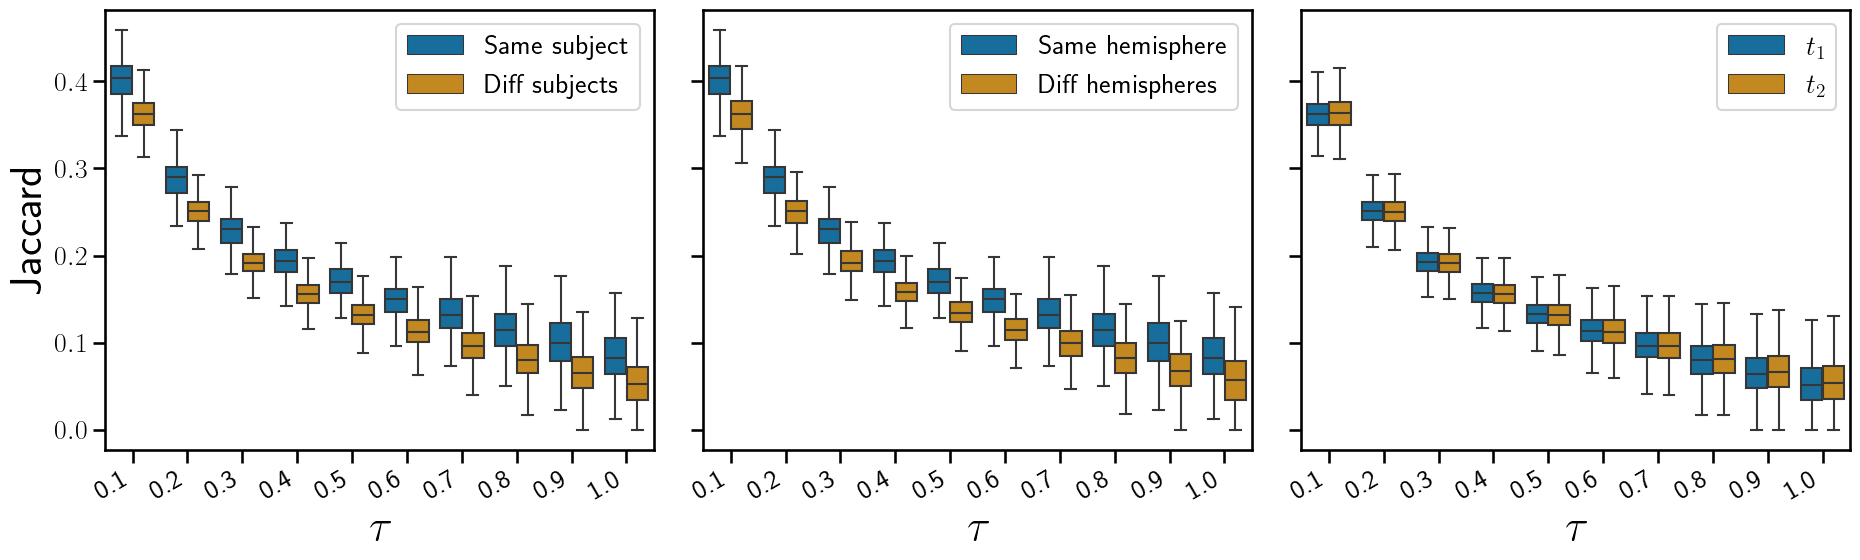

In [31]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(19,6)) 

palette='colorblind'

g1=sns.boxplot(data=to_plot_ic, x='$\\tau$', y='Jacc', hue='kind', palette=palette, showfliers=False, linewidth=1.5, ax=ax[0])
g1.set_xticklabels(np.round(thresholds,2),rotation=30, ha='right')
g1.set_ylabel("Jaccard")
g1.legend(loc=0)

g2=sns.boxplot(data=to_plot_lr, x='$\\tau$', y='Jacc', hue='kind', palette=palette, showfliers=False, linewidth=1.5, ax=ax[1])
g2.set_xticklabels(np.round(thresholds,2),rotation=30, ha='right')
g2.set_ylabel("")
g2.legend(loc=0)

g3=sns.boxplot(data=to_plot_t1t2, x='$\\tau$', y='Jacc', hue='kind', palette=palette, showfliers=False, linewidth=1.5, ax=ax[2])
g3.set_xticklabels(np.round(thresholds,2),rotation=30, ha='right')
g3.set_ylabel("")
g3.legend(loc=0)

plt.tight_layout()
# plt.savefig(fig_dir+"1.0_Jacc_all.pdf", dpi=1200, bbox_inches='tight')
plt.show()